# **Yolo V8**

In [1]:
# @title Setup Environment
%%capture
!git clone https://huggingface.co/OpenSistemas/YOLOv8-crack-seg
!pip install ultralytics
!pip install opencv-python-headless

import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from PIL import Image
import subprocess
import os
from google.colab import drive




In [2]:
# @title Mount your Google Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# @title Choose you driectory from Google Drive
image_directory = '/content/drive/MyDrive/Crack_2' # @param {type:"string"}
image_paths = {image_name: os.path.join(image_directory, image_name)
              for image_name in os.listdir(image_directory)
              if image_name.endswith(('.jpg', '.jpeg', '.png'))}


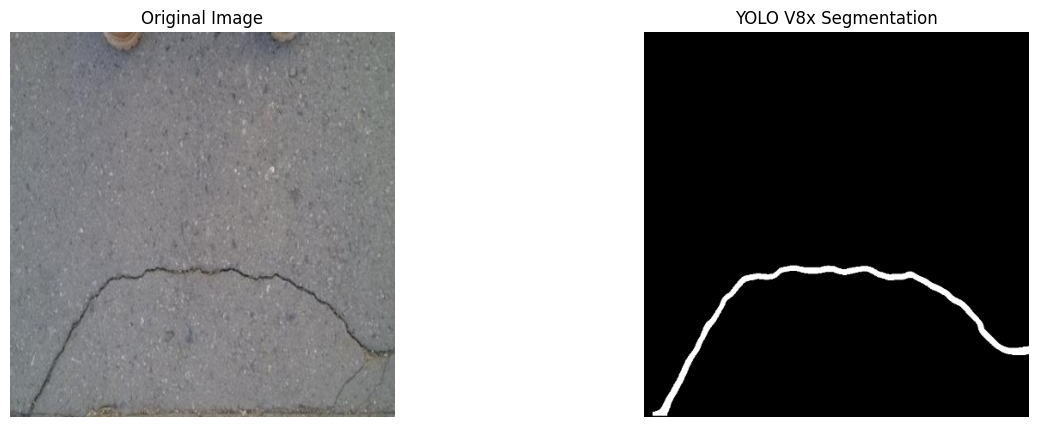

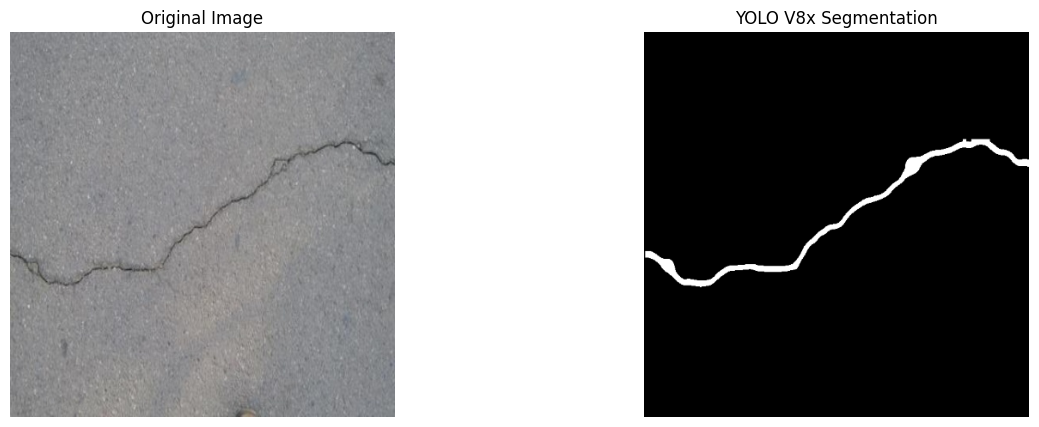

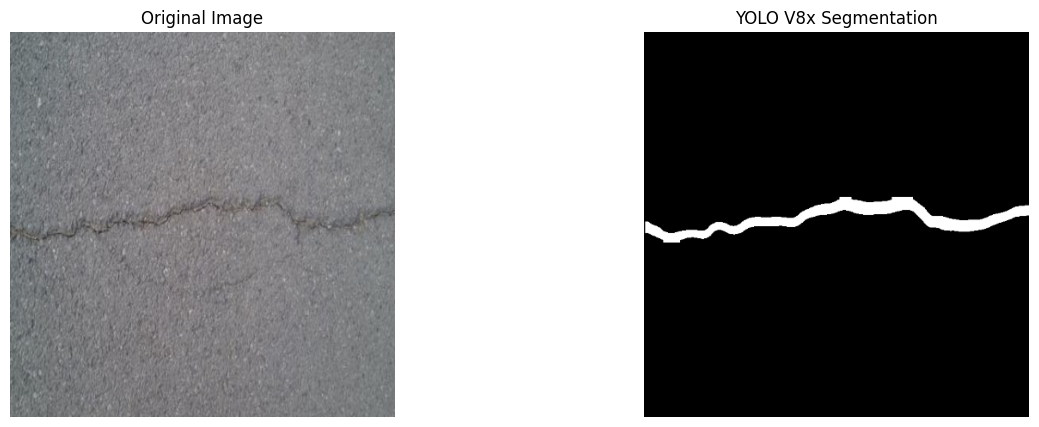

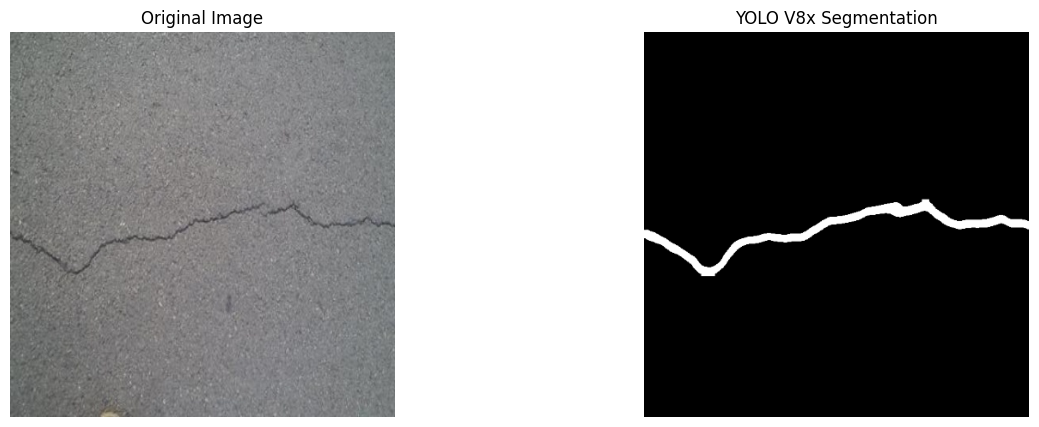

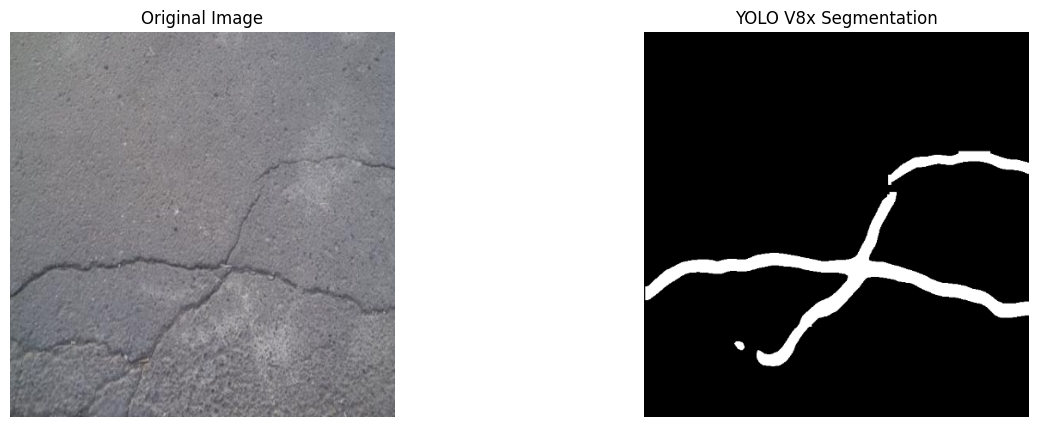

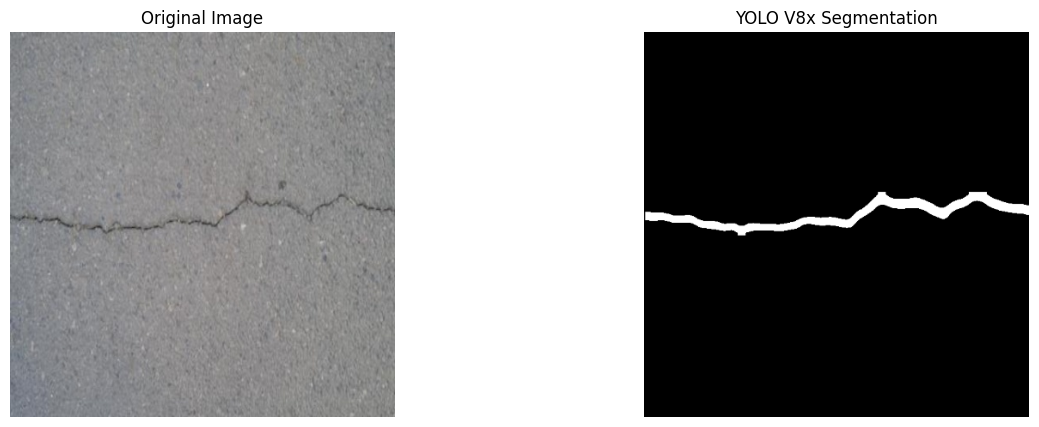

In [4]:
# @title Segmentation

# Load YOLOv8x Model
yolo_model = YOLO('YOLOv8-crack-seg/yolov8x/weights/best.pt')

# Function to Segment Images using YOLOv8x
def segment_image_yolo(image):
    results = yolo_model(image)
    masks = []
    for result in results:
        if result.masks is not None:
            masks.extend(result.masks.data.numpy())
    return masks

# Function to Display and Save Results
def display_and_save_results(original_image, yolo_masks, output_dir, image_name):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original_image)
    plt.axis('off')

    # Save original image
    original_image_path = os.path.join(output_dir, f'{image_name}_original.png')
    plt.imsave(original_image_path, original_image)

    plt.subplot(1, 2, 2)
    plt.title("YOLO V8x Segmentation")

    combined_yolo_mask = np.zeros((original_image.shape[0], original_image.shape[1]), dtype=np.uint8)
    for mask in yolo_masks:
        mask_resized = cv2.resize(mask, (original_image.shape[1], original_image.shape[0]))
        combined_yolo_mask = np.maximum(combined_yolo_mask, mask_resized)

    plt.imshow(combined_yolo_mask, cmap='gray')
    plt.axis('off')

    # Save YOLO segmentation image
    yolo_mask_path = os.path.join(output_dir, f'{image_name}_yolo_mask.png')
    plt.imsave(yolo_mask_path, combined_yolo_mask, cmap='gray')

    plt.show()

# Process and Save Images
def process_images(image_directory, output_dir):
    os.makedirs(output_dir, exist_ok=True)  # Create output directory if it doesn't exist

    for image_name in os.listdir(image_directory):
        if image_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(image_directory, image_name)
            image = np.array(Image.open(image_path))
            yolo_masks = segment_image_yolo(image)
            display_and_save_results(image, yolo_masks, output_dir, image_name.split('.')[0])

# Path to the directory containing images
output_dir = '/content/yolo_segmentation'

# Process and save images
process_images(image_directory, output_dir)

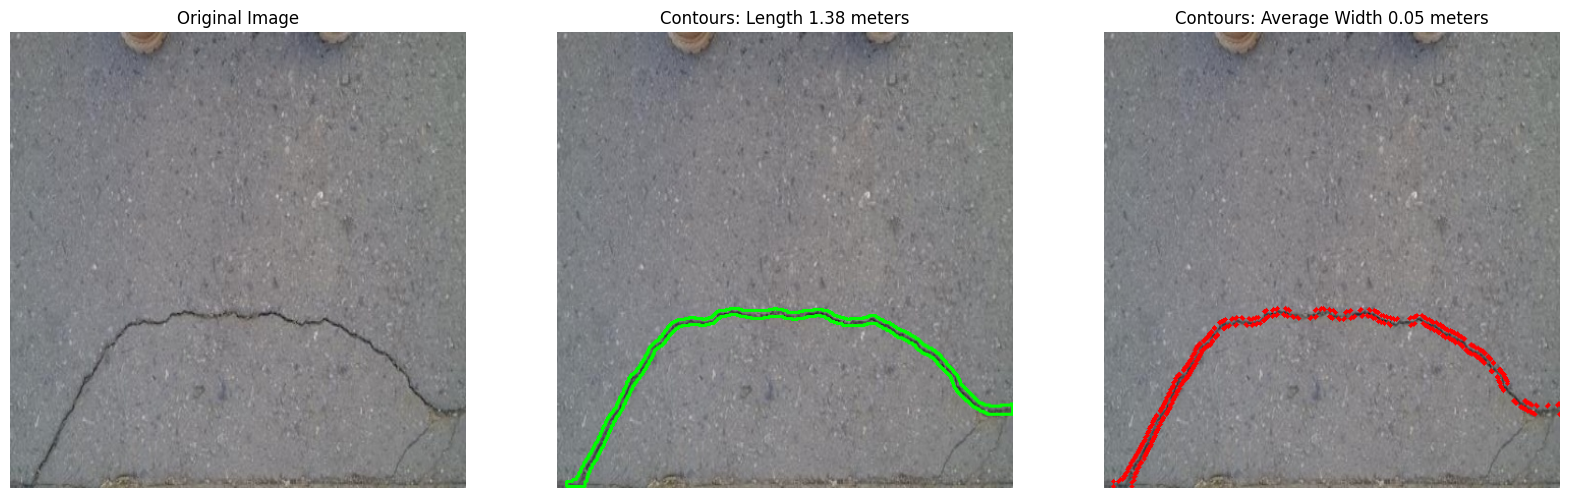

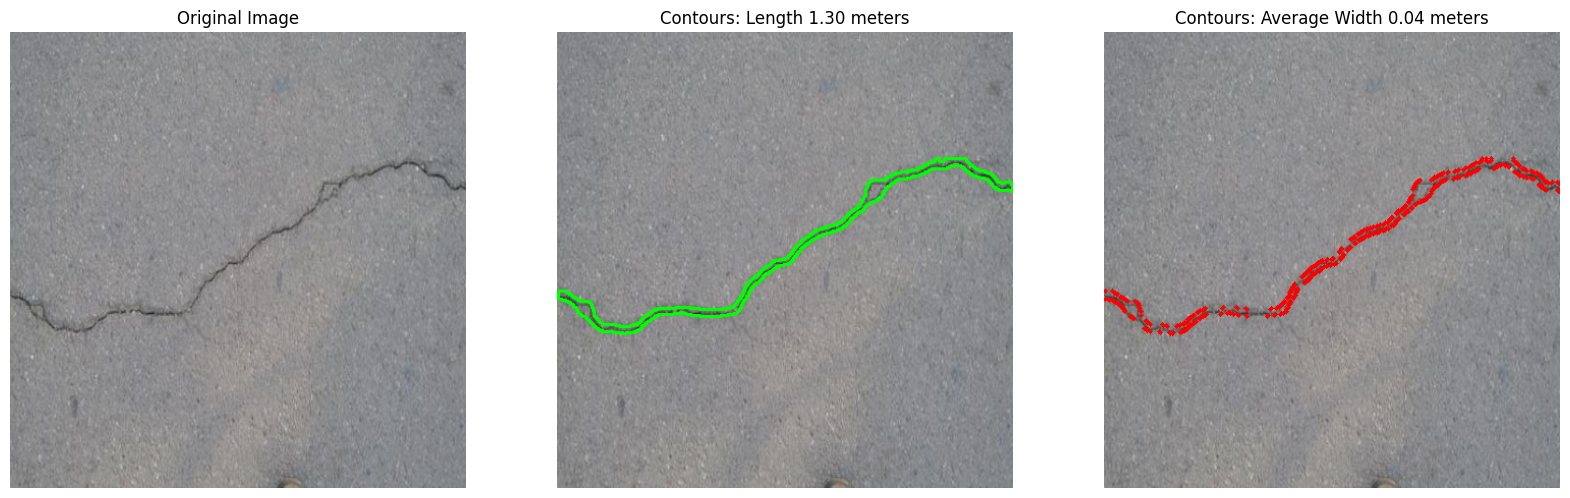

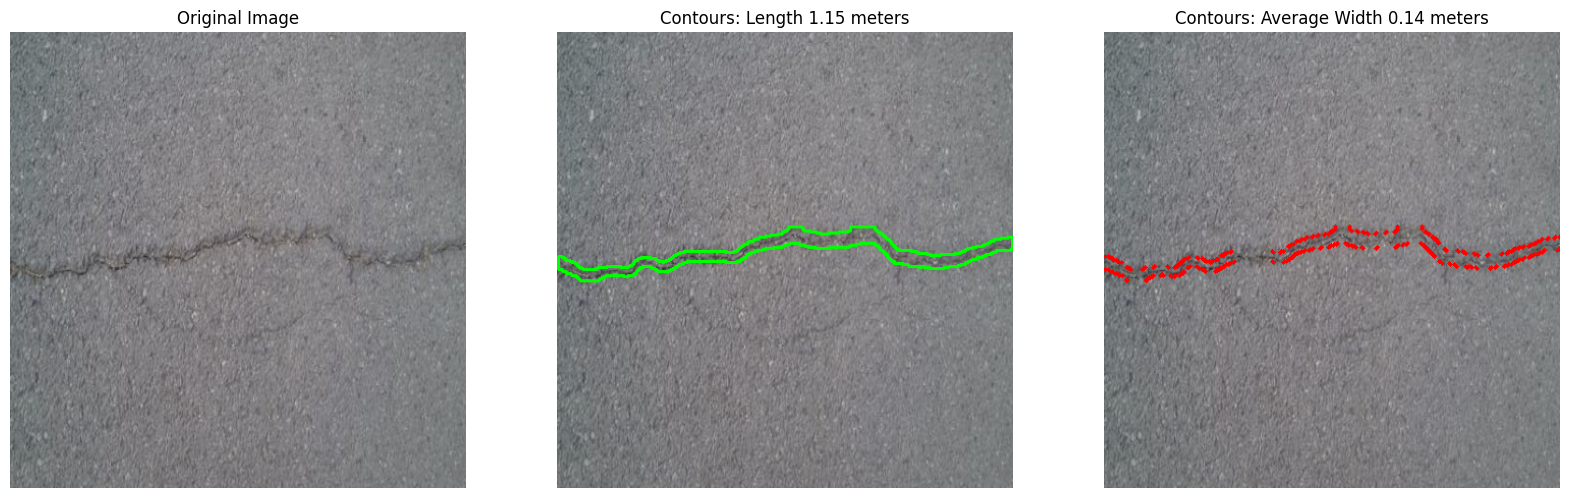

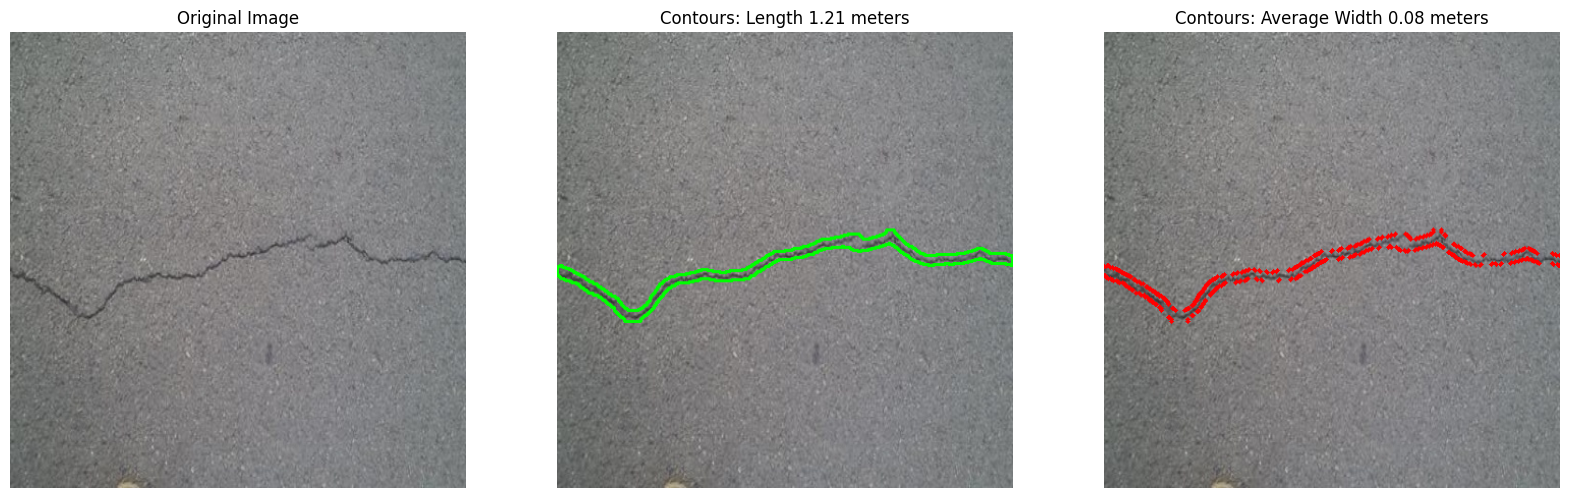

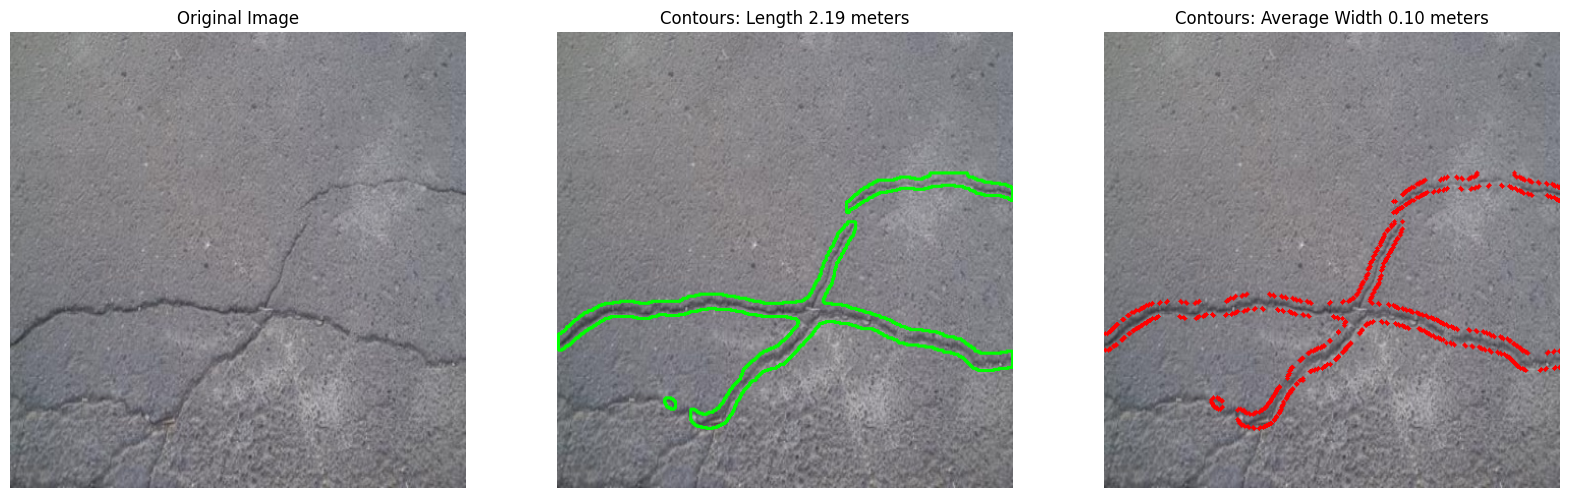

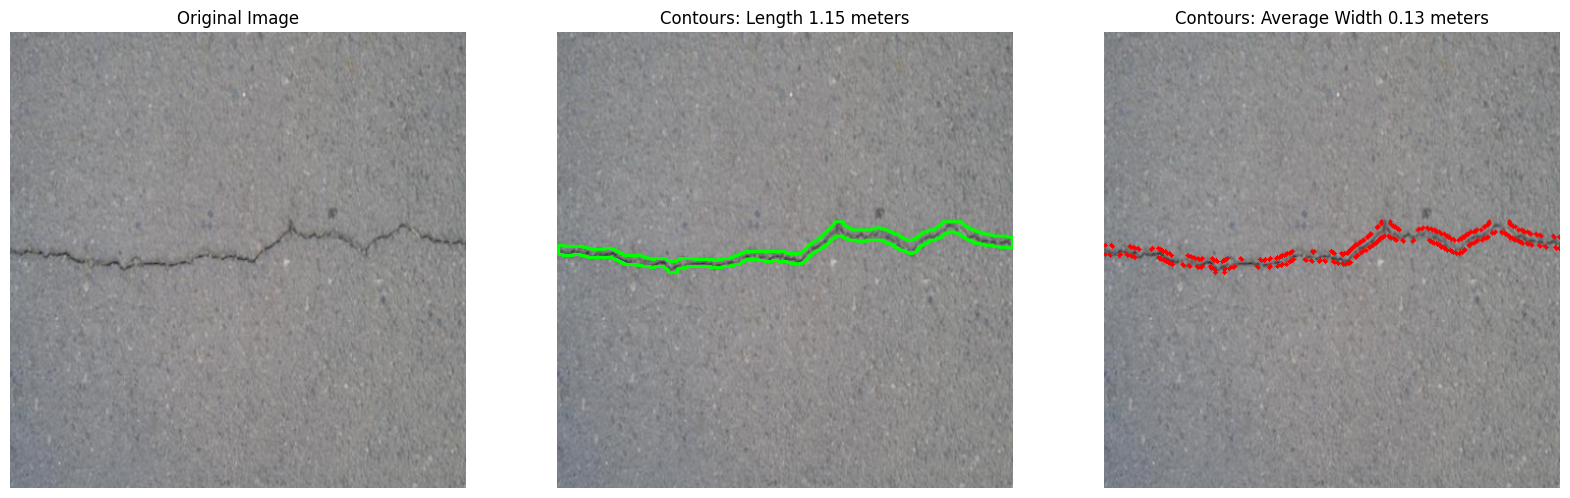

In [5]:
# @title Calculate Length and Width
# Function to Segment Images using YOLOv8x
def segment_image_yolo(image):
    results = yolo_model(image)
    masks = []
    for result in results:
        if result.masks is not None:
            masks.extend(result.masks.data.numpy())
    return masks

# Function to Fill Contours
def fill_contours(mask):
    # Convert mask to uint8
    mask = (mask * 255).astype(np.uint8)

    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Fill contours
    filled_mask = np.zeros_like(mask)
    cv2.drawContours(filled_mask, contours, -1, 255, thickness=cv2.FILLED)

    return filled_mask, contours

# Function to Calculate Contour Length and Average Width
def calculate_contour_metrics(contours, filled_mask, scaling_factor):
    contour_length = 0
    widths = []

    for contour in contours:
        contour_length += cv2.arcLength(contour, True)

        # Calculate the width at various points
        for point in contour:
            x, y = point[0]
            row = filled_mask[y, :]
            width = np.sum(row > 0)
            widths.append(width)

    # Convert pixel length and width to real-world length and width (meters)
    real_world_length = contour_length * scaling_factor
    real_world_widths = [width * scaling_factor for width in widths]
    average_width = np.mean(real_world_widths)

    return real_world_length, average_width

# Function to Display Results
def display_results(original_image, contours, contour_length, average_width):
    plt.figure(figsize=(20, 10))

    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(original_image)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title(f"Contours: Length {contour_length:.2f} meters")
    image_with_contours = np.copy(original_image)

    # Draw contours
    for contour in contours:
        cv2.drawContours(image_with_contours, [contour], -1, (0, 255, 0), 2)  # Green contours

    plt.imshow(image_with_contours)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title(f"Contours: Average Width {average_width:.2f} meters")
    image_with_width_annotations = np.copy(original_image)

    # Draw width annotations
    for contour in contours:
        for point in contour:
            x, y = point[0]
            cv2.circle(image_with_width_annotations, (x, y), 2, (255, 0, 0), -1)  # Red points for width measurement

    plt.imshow(image_with_width_annotations)
    plt.axis('off')

    plt.show()

# Process and Display Images
def process_images(image_directory):
    # @markdown Enter Camera Distance(meter) and Resolution of picture
    camera_distance = 0.5  # @param {type:"number"}
    image_resolution = 448 # @param {type:"number"}
    scaling_factor = camera_distance / image_resolution

    for image_name in os.listdir(image_directory):
        if image_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(image_directory, image_name)
            image = np.array(Image.open(image_path))
            yolo_masks = segment_image_yolo(image)

            # Combine YOLO masks into one
            combined_yolo_mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
            for mask in yolo_masks:
                mask_resized = cv2.resize(mask, (image.shape[1], image.shape[0]))
                combined_yolo_mask = np.maximum(combined_yolo_mask, mask_resized)

            # Fill contours
            filled_mask, contours = fill_contours(combined_yolo_mask)

            # Calculate contour length and average width
            contour_length, average_width = calculate_contour_metrics(contours, filled_mask, scaling_factor)

            # Display results
            display_results(image, contours, contour_length, average_width)


process_images(image_directory)


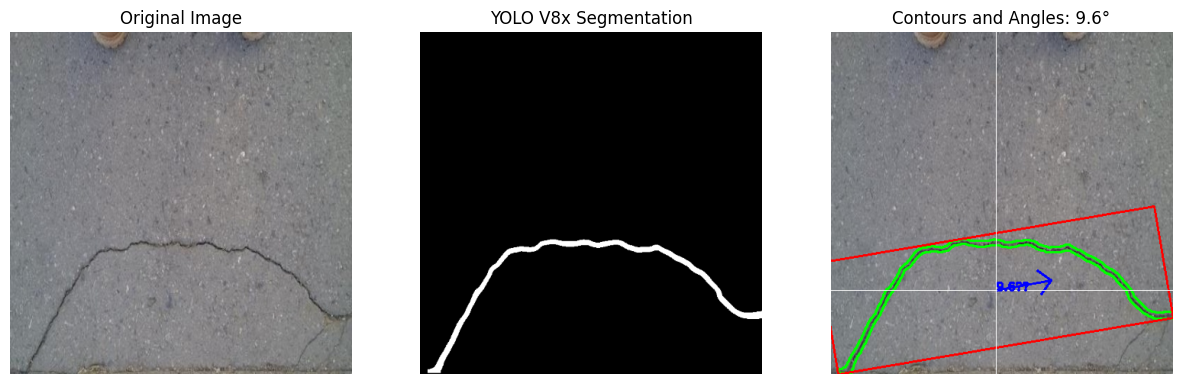

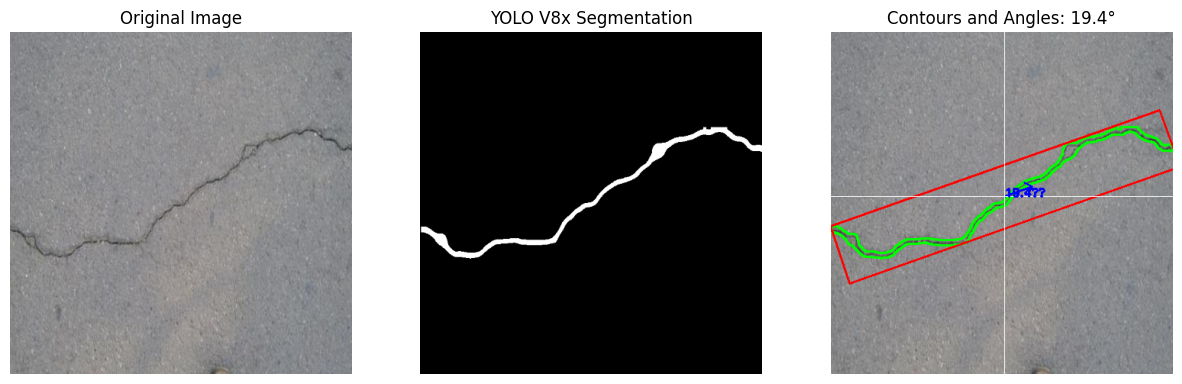

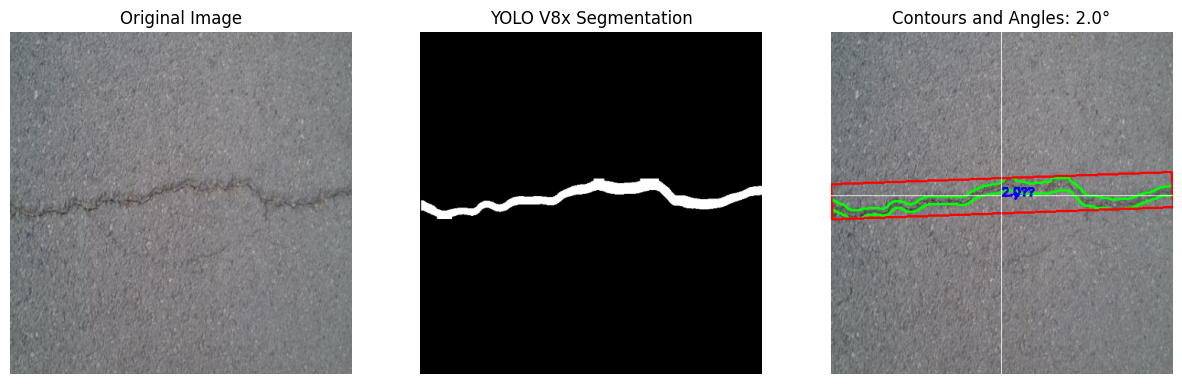

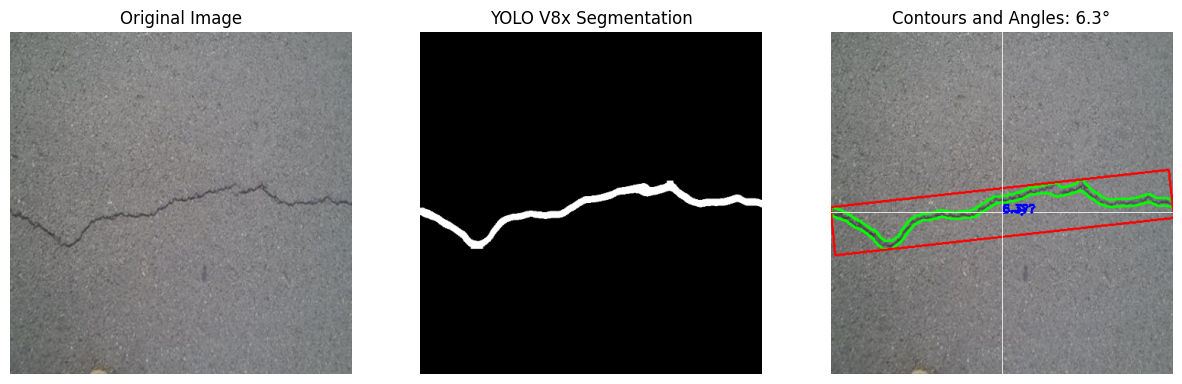

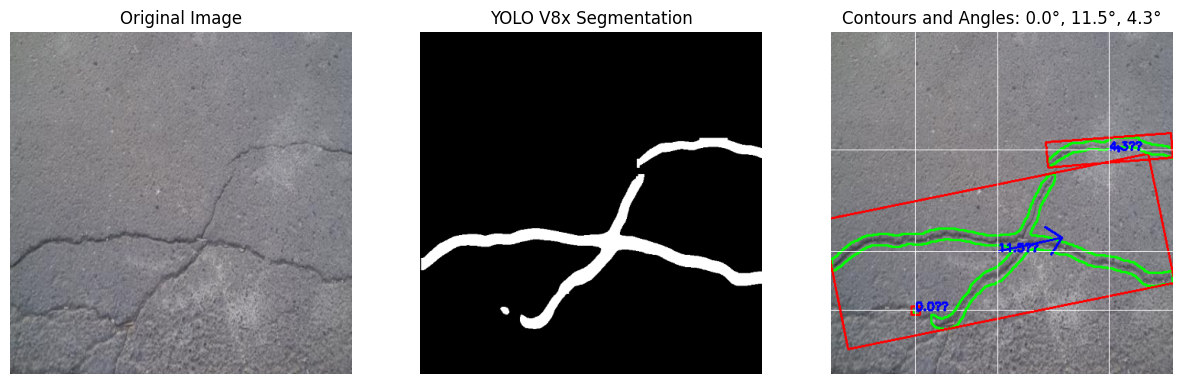

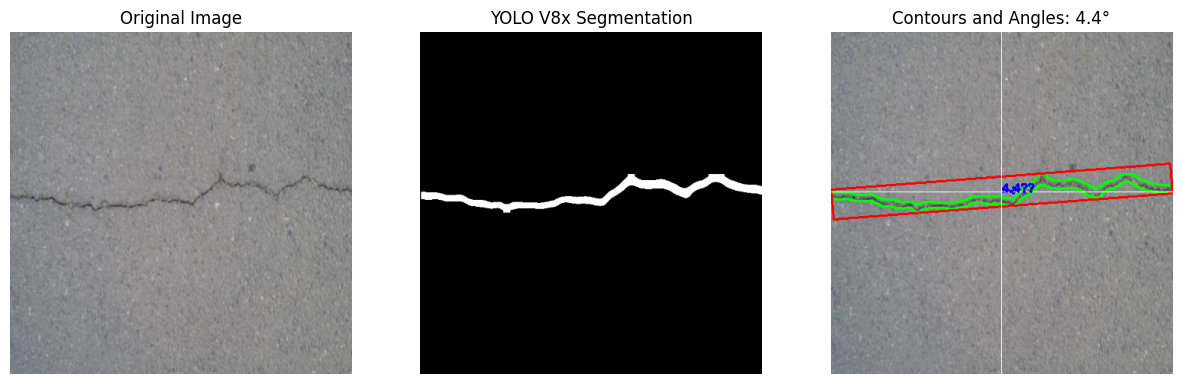

In [6]:
# @title Calculate Angle
# Function to Segment Images using YOLOv8x
def segment_image_yolo(image):
    results = yolo_model(image)
    masks = []
    for result in results:
        if result.masks is not None:
            masks.extend(result.masks.data.numpy())
    return masks

# Function to extract contours and calculate their angles
def extract_contours_and_angles(mask):
    # Ensure mask is in CV_8UC1 format
    if mask.dtype != np.uint8:
        mask = (mask * 255).astype(np.uint8)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    angles = []
    for contour in contours:
        if len(contour) >= 5:  # Fit ellipse requires at least 5 points
            rect = cv2.minAreaRect(contour)
            angle = rect[-1]
            if angle < -45:
                angle = 90 + angle
            elif angle > 45:
                angle = 90 - angle
            angles.append(abs(angle))
    return contours, angles

# Function to display results with angle indication
def display_results(original_image, combined_yolo_mask, contours, angles):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(original_image)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("YOLO V8x Segmentation")
    plt.imshow(combined_yolo_mask, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title(f"Contours and Angles: {', '.join([f'{angle:.1f}°' for angle in angles])}")
    contour_image = cv2.cvtColor(original_image, cv2.COLOR_RGB2BGR)
    for contour, angle in zip(contours, angles):
        cv2.drawContours(contour_image, [contour], -1, (0, 255, 0), 2)
        rect = cv2.minAreaRect(contour)
        box = cv2.boxPoints(rect)
        box = np.intp(box)
        cv2.drawContours(contour_image, [box], 0, (0, 0, 255), 2)

        # Calculate the arrow points to indicate angle
        center = np.intp(rect[0])
        box_points = np.intp(rect[1])
        width, height = box_points
        angle_rad = np.deg2rad(angle)
        length = min(width, height) / 2

        end_x = int(center[0] + length * np.cos(angle_rad))
        end_y = int(center[1] - length * np.sin(angle_rad))

        cv2.arrowedLine(contour_image, tuple(center), (end_x, end_y), (255, 0, 0), 2, tipLength=0.3)

        # Draw vertical and horizontal lines
        cv2.line(contour_image, (center[0], 0), (center[0], contour_image.shape[0]), (255, 255, 255), 1)
        cv2.line(contour_image, (0, center[1]), (contour_image.shape[1], center[1]), (255, 255, 255), 1)

        cv2.putText(contour_image, f"{angle:.1f}°", tuple(center), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.show()

# Process and Display Images
def process_images(image_directory):
    for image_name in os.listdir(image_directory):
        if image_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(image_directory, image_name)
            image = np.array(Image.open(image_path))
            yolo_masks = segment_image_yolo(image)

            combined_yolo_mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
            for mask in yolo_masks:
                mask_resized = cv2.resize(mask, (image.shape[1], image.shape[0]))
                combined_yolo_mask = np.maximum(combined_yolo_mask, mask_resized)

            contours, angles = extract_contours_and_angles(combined_yolo_mask)
            display_results(image, combined_yolo_mask, contours, angles)

# Process and display images
process_images(image_directory)


# **UNET**

In [7]:
# @title Setup Environment
!git clone https://github.com/yakhyo/crack-segmentation
%cd /content/crack-segmentation
import subprocess
import os
from google.colab import drive
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

Cloning into 'crack-segmentation'...
remote: Enumerating objects: 159, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 159 (delta 22), reused 25 (delta 16), pack-reused 108
Receiving objects: 100% (159/159), 109.28 MiB | 25.63 MiB/s, done.
Resolving deltas: 100% (57/57), done.
/content/crack-segmentation


In [19]:
# @title Mount your Google Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# @title Choose you driectory from Google Drive
image_directory = '/content/drive/MyDrive/Crack_2' # @param {type:"string"}
image_dict = {image_name: os.path.join(image_directory, image_name)
              for image_name in os.listdir(image_directory)
              if image_name.endswith(('.jpg', '.jpeg', '.png'))}


Processed CFD_004.jpg, output saved to /content/crack-segmentation/unet_segmentation/output_CFD_004.jpg


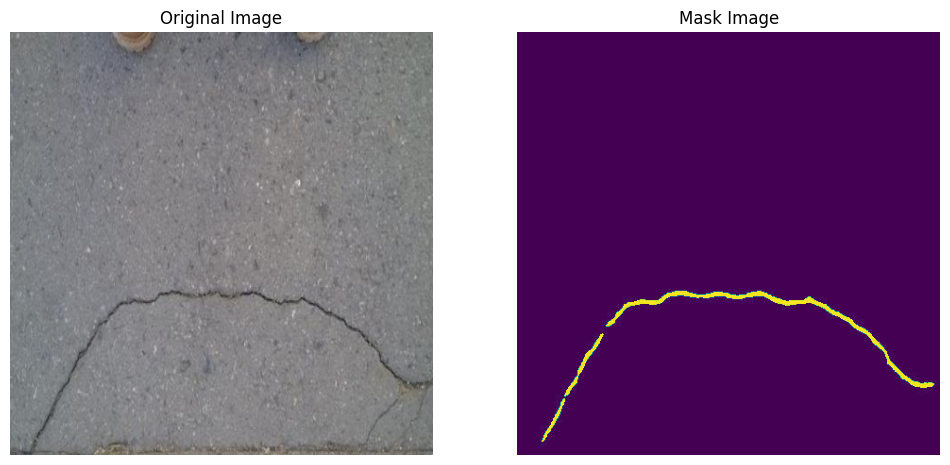

Processed CFD_018.jpg, output saved to /content/crack-segmentation/unet_segmentation/output_CFD_018.jpg


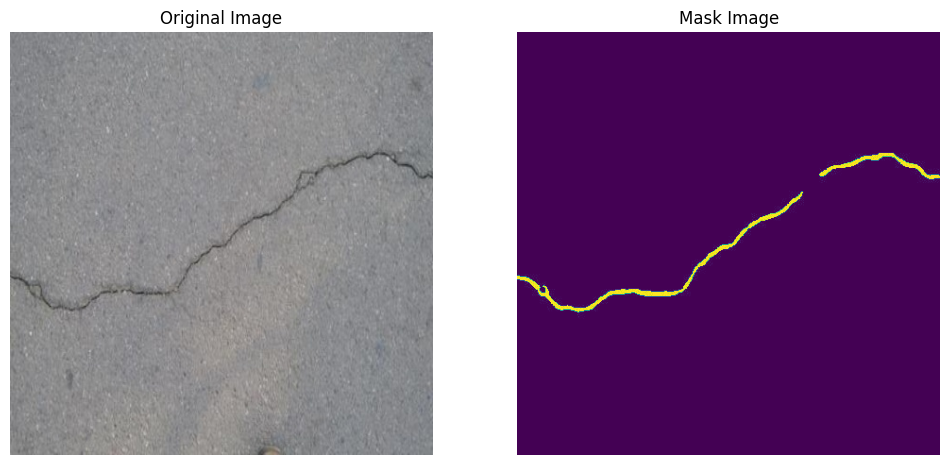

Processed CFD_009.jpg, output saved to /content/crack-segmentation/unet_segmentation/output_CFD_009.jpg


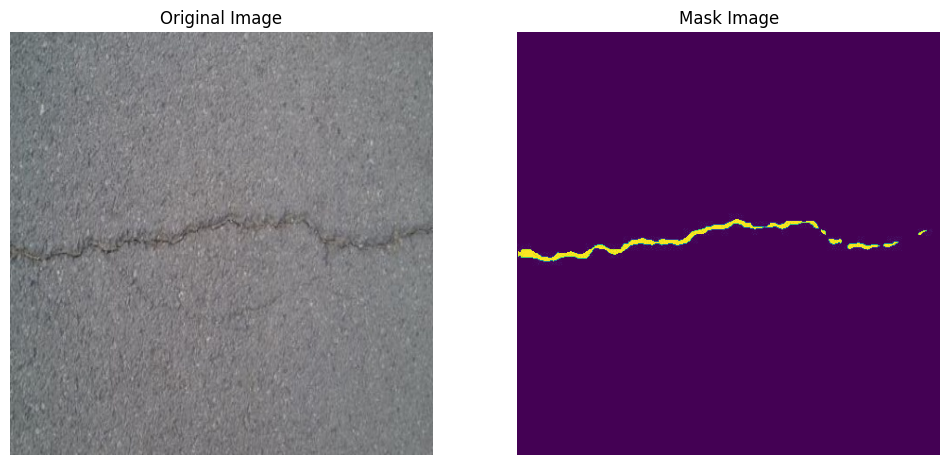

Processed CFD_001.jpg, output saved to /content/crack-segmentation/unet_segmentation/output_CFD_001.jpg


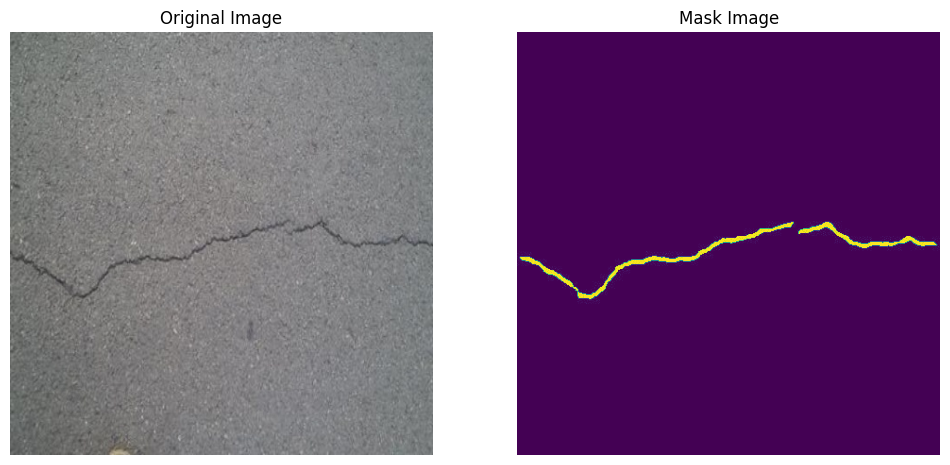

Processed CFD_002.jpg, output saved to /content/crack-segmentation/unet_segmentation/output_CFD_002.jpg


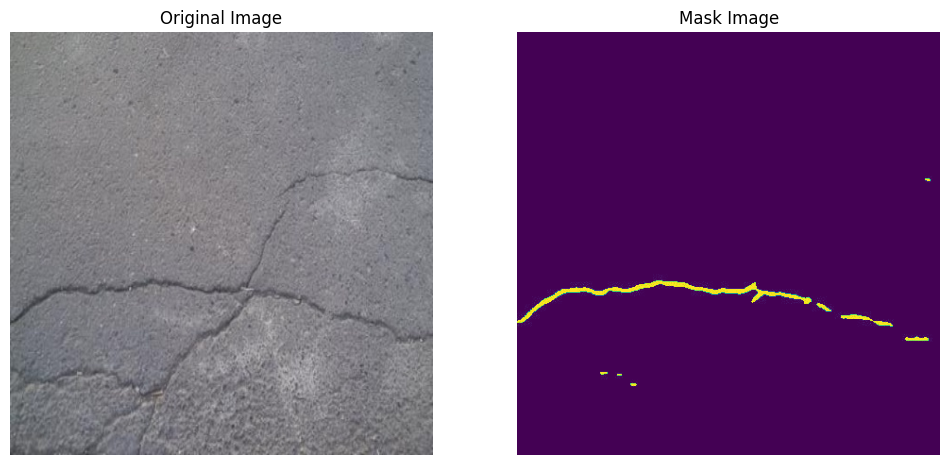

Processed CFD_010.jpg, output saved to /content/crack-segmentation/unet_segmentation/output_CFD_010.jpg


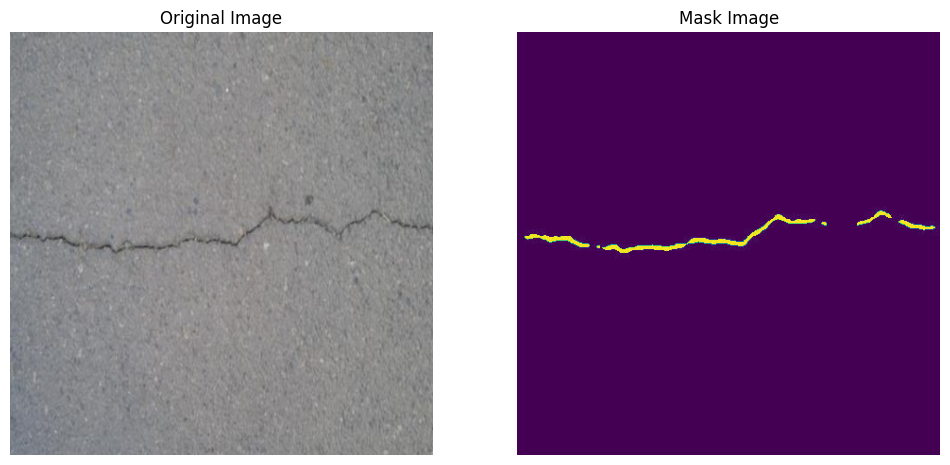

In [9]:
# @title Segmentation
# Path to the weights file
weights_path = '/content/crack-segmentation/weights/model.pt'

# Output directory
output_dir = '/content/unet_segmentation'
os.makedirs(output_dir, exist_ok=True)  # Ensure the output directory exists

# Iterate through the dictionary and run the inference script
for image_name, image_path in image_dict.items():
    try:
        output_path = os.path.join(output_dir, f'output_{image_name}')
        command = [
            'python', 'inference.py',
            '--weights', weights_path,
            '--input', image_path,
            '--output', output_path
        ]

        # Run the command and capture the output
        result = subprocess.run(command, capture_output=True, text=True)

        # Check for errors
        if result.returncode != 0:
            print(f"Error processing {image_name}: {result.stderr}")
            continue

        # Print status
        print(f'Processed {image_name}, output saved to {output_path}')

        # Check if output file was created
        if not os.path.exists(output_path):
            print(f"Error: Output file {output_path} not found.")
            continue

        # Display original and mask images
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))

        # Original image
        original_img = Image.open(image_path)
        ax[0].imshow(original_img)
        ax[0].set_title('Original Image')
        ax[0].axis('off')

        # Mask image
        mask_img = Image.open(output_path)
        ax[1].imshow(mask_img)
        ax[1].set_title('Mask Image')
        ax[1].axis('off')

        plt.show()

    except Exception as e:
        print(f"An error occurred while processing {image_name}: {e}")


Processed CFD_004.jpg, output saved to temp_output_CFD_004.jpg


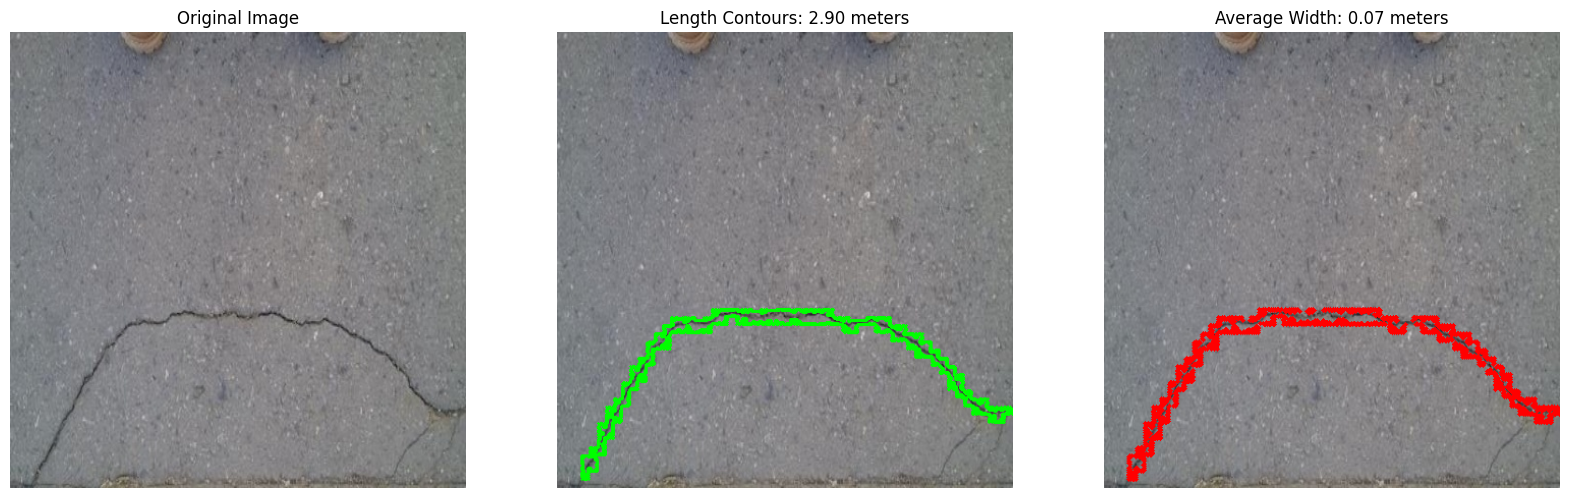

Processed CFD_018.jpg, output saved to temp_output_CFD_018.jpg


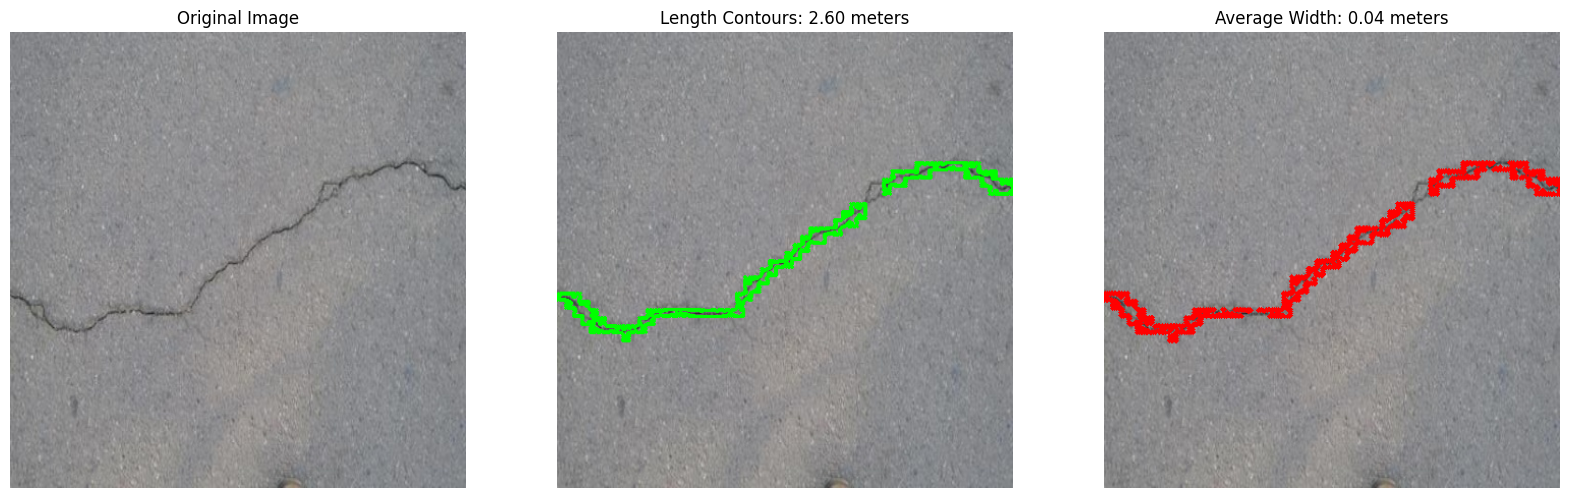

Processed CFD_009.jpg, output saved to temp_output_CFD_009.jpg


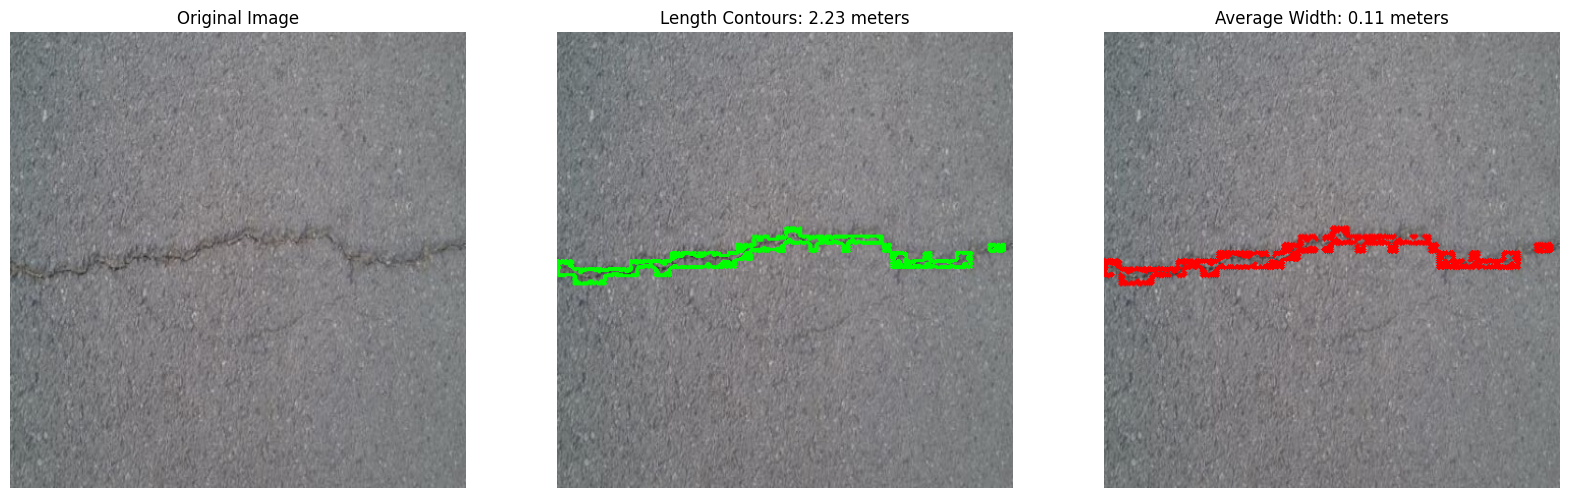

Processed CFD_001.jpg, output saved to temp_output_CFD_001.jpg


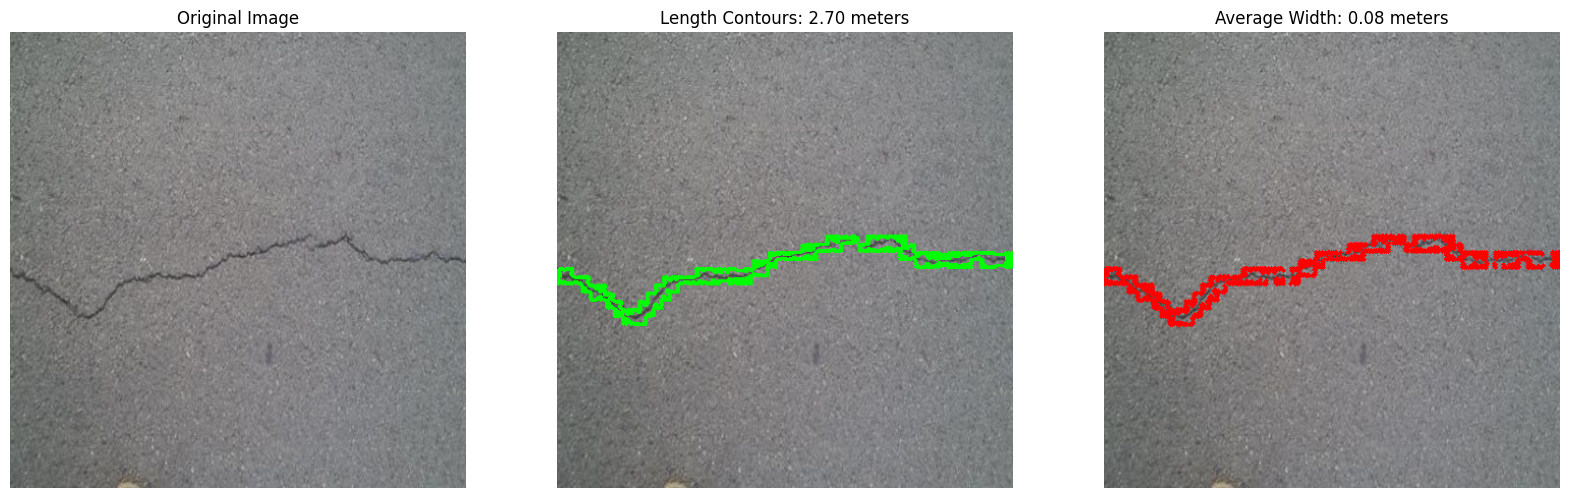

Processed CFD_002.jpg, output saved to temp_output_CFD_002.jpg


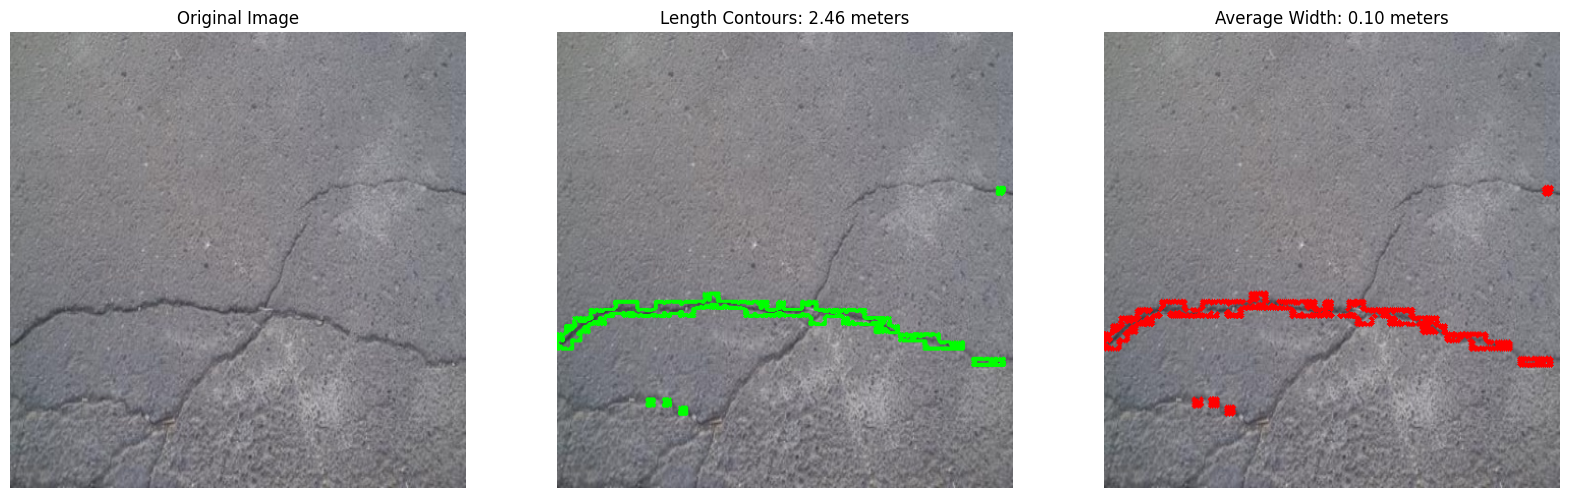

Processed CFD_010.jpg, output saved to temp_output_CFD_010.jpg


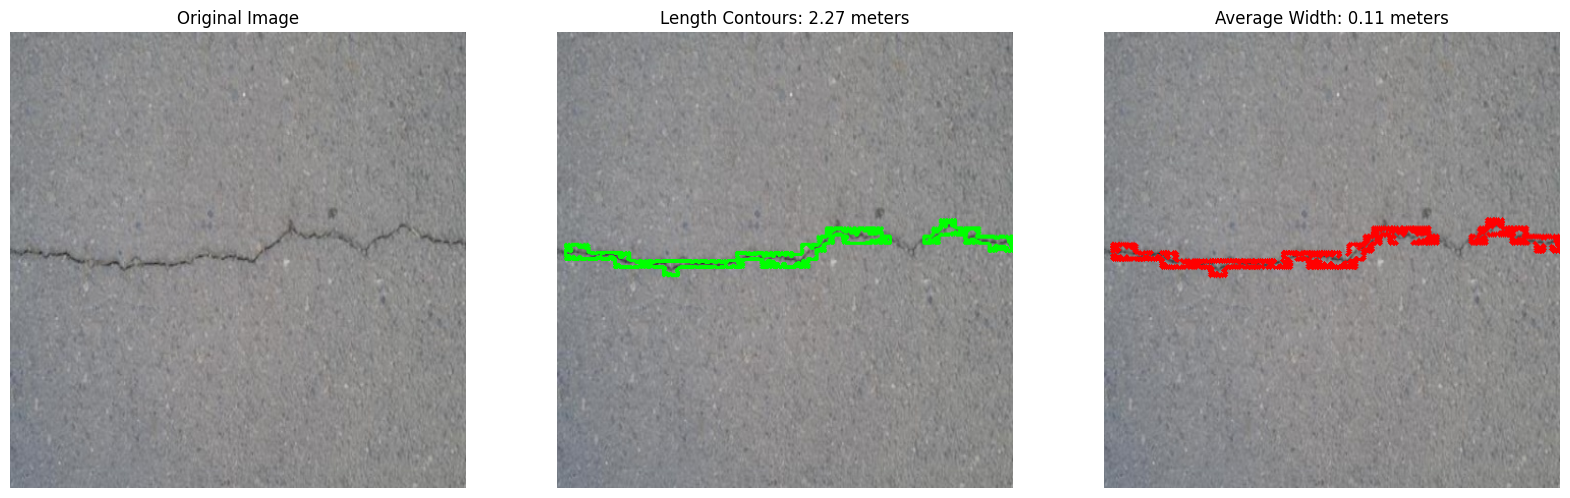

In [11]:
# @title Calculate Length and Width

# Function to Fill Contours
def fill_contours(mask):
    # Convert mask to uint8
    mask = (mask * 255).astype(np.uint8)

    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Fill contours
    filled_mask = np.zeros_like(mask)
    cv2.drawContours(filled_mask, contours, -1, 255, thickness=cv2.FILLED)

    return filled_mask, contours

# Function to Calculate Contour Length and Average Width
def calculate_contour_metrics(contours, filled_mask, scaling_factor):
    contour_length = 0
    widths = []

    for contour in contours:
        contour_length += cv2.arcLength(contour, True)

        # Calculate the width at various points
        for point in contour:
            x, y = point[0]
            row = filled_mask[y, :]
            width = np.sum(row > 0)
            widths.append(width)

    # Convert pixel length and width to real-world length and width
    real_world_length = contour_length * scaling_factor
    real_world_widths = [width * scaling_factor for width in widths]
    average_width = np.mean(real_world_widths)

    return real_world_length, average_width

# Function to Display Results
def display_results(original_image, filled_mask, contours, contour_length, average_width):
    fig, ax = plt.subplots(1, 3, figsize=(20, 10))

    # Original Image
    ax[0].imshow(original_image)
    ax[0].set_title("Original Image")
    ax[0].axis('off')

    # Length Contours
    length_contours_img = original_image.copy()
    cv2.drawContours(length_contours_img, contours, -1, (0, 255, 0), 2)  # Green contours for length
    ax[1].imshow(length_contours_img)
    ax[1].set_title(f"Length Contours: {contour_length:.2f} meters")
    ax[1].axis('off')

    # Width Contours
    width_contours_img = original_image.copy()
    for contour in contours:
        for point in contour:
            x, y = point[0]
            cv2.circle(width_contours_img, (x, y), 2, (255, 0, 0), -1)  # Red points for width measurement
    ax[2].imshow(width_contours_img)
    ax[2].set_title(f"Average Width: {average_width:.2f} meters")
    ax[2].axis('off')

    plt.show()

# Iterate through the dictionary and run the inference script
def process_images(image_dict, weights_path):
    # @markdown Enter Camera Distance(meter) and Resolution of picture
    camera_distance = 0.5  # @param {type:"number"}
    image_resolution = 448 # @param {type:"number"}
    scaling_factor = camera_distance / image_resolution

    for image_name, image_path in image_dict.items():
        try:
            # Define output path (temporary location)
            output_path = f'temp_output_{image_name}'
            command = [
                'python', 'inference.py',
                '--weights', weights_path,
                '--input', image_path,
                '--output', output_path
            ]

            # Run the command and capture the output
            result = subprocess.run(command, capture_output=True, text=True)

            # Check for errors
            if result.returncode != 0:
                print(f"Error processing {image_name}: {result.stderr}")
                continue

            # Print status
            print(f'Processed {image_name}, output saved to {output_path}')

            # Check if output file was created
            if not os.path.exists(output_path):
                print(f"Error: Output file {output_path} not found.")
                continue

            # Display original and mask images
            original_img = np.array(Image.open(image_path))
            mask_img = np.array(Image.open(output_path))

            # Process mask and calculate metrics
            filled_mask, contours = fill_contours(mask_img)
            contour_length, average_width = calculate_contour_metrics(contours, filled_mask, scaling_factor)

            # Display results
            display_results(original_img, filled_mask, contours, contour_length, average_width)

        except Exception as e:
            print(f"An error occurred while processing {image_name}: {e}")

# Path to the weights file
weights_path = '/content/crack-segmentation/weights/model.pt'

# Process and display images
process_images(image_dict, weights_path)
